In [40]:
%autosave 0
from __future__ import absolute_import, division, print_function
%pylab inline
import numpy.matlib
import scipy.io
import cv2
import glob
import re
import time

Autosave disabled
Populating the interactive namespace from numpy and matplotlib


C:\Users\danie\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cov', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Eigenfaces

This tutorial is all about eigenfaces. We have a database of images that can be downloaded at the website. The aim of this tutorial is to show a method for reconstructing a face by using the eigenfaces method.

## Creating the database

### Reading face images

Read all images with the suffix '.png' from the subdirectory './eigenfaces/'. 

All images must have the same size: N x N pixels (N = 64).

In [41]:
N = 64
filenames = sort(glob.glob('eigenfaces/*.png'))
num_images = len(filenames)
images = zeros((N*N, num_images))
for n in range(num_images):
    img = cv2.imread(filenames[n], cv2.IMREAD_GRAYSCALE)
    assert img.shape == (N, N), 'Image {0} of wrong size'.format(filenames[n])
    images[:,n] = img.reshape((N * N))
print('Database contains {0} images'.format(num_images))

Database contains 133 images


### Displaying the images

In [42]:
def create_overview_picture(data, num_cols = 10, background_color = 255):
    num_images = len(data[0])
    num_rows = int(ceil(num_images / num_cols))
    overview = background_color * ones((num_rows * N, num_cols * N))
    for j in range(num_rows):
        for i in range(num_cols):
            n = j * num_cols + i
            if (n < num_images):
                img = data[:,n].reshape((N, N))
                overview[j*N:(j+1)*N, i*N:(i+1)*N] = img
    return overview, num_cols, num_rows

In [43]:
overview_images, num_cols, num_rows = create_overview_picture(images)

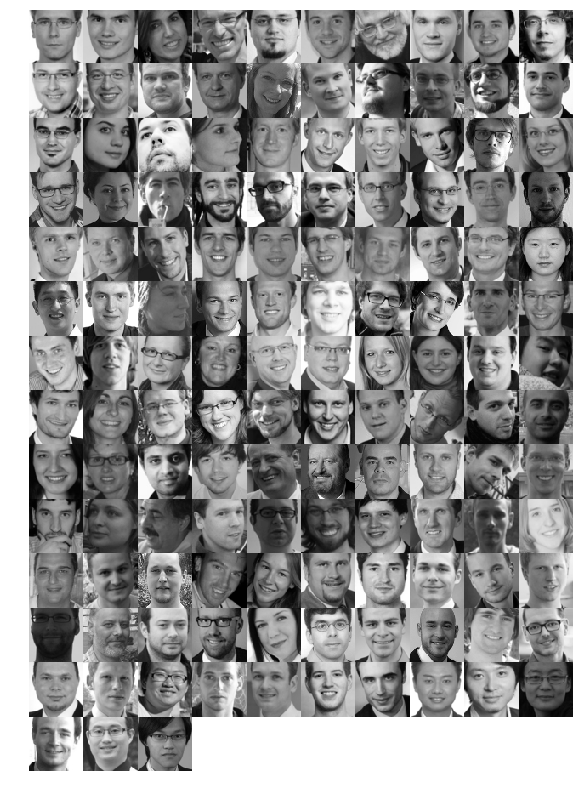

In [44]:
figure(figsize(num_cols, num_rows))
plt.imshow(overview_images, 'gray')
plt.axis('off');

### Select test image

Choose a test image that should be reconstructed (for example 'stromer'). Extract the image from the database, so that we can compare it later on to the reconstructed one.

In [45]:
n = [idx for idx, filename in enumerate(filenames) if re.search('stromer', filename)][0]
test = images[:, n]

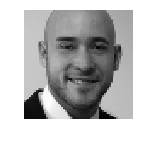

In [46]:
figure(figsize(2, 2))
plt.imshow(test.reshape((N, N)), 'gray')
plt.axis('off');

In [47]:
train = np.delete(images, n, 1)
num_images -= 1

## Principal Component Analysis (PCA)

### Computation of the average face of the training set

$$
  \pmb{\mu} = \frac{1}{m} \sum_{i=1}^m \pmb{x}_i
$$

In [48]:
avg = np.mean(train,1) # 1-D array which ahs to be reshaped to 64x64

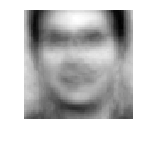

In [49]:
figure(figsize(2, 2))
plt.imshow(avg.reshape((N, N)), 'gray')
plt.axis('off');

### Subtract the average face from each training image

$$\pmb{X} = [\pmb{x}_1 - \pmb{\mu}, \pmb{x}_2 - \pmb{\mu}, \ldots, \pmb{x}_m - \pmb{\mu}]$$

In [50]:
# repmat: Repeat a matrix MxN times -> we subtract the mean from every image and put it in the database
X = train - numpy.matlib.repmat(avg.reshape((N * N, 1)), 1, len(train[0]))

### Compute the eigenfaces

$$\pmb{X} = \pmb{U} \cdot \pmb{S} \cdot \pmb{V}^\mathsf{T}, \quad \pmb{X} \in \mathbb{R}^{d \times m}$$

http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.svd.html

The SVD is commonly written as $\pmb{X} = \pmb{U} \cdot \pmb{S} \cdot \pmb{V}^\mathsf{T}$.<br>
The $\mathtt{v}$ returned by this function is $\pmb{V}^\mathsf{T}$ and $\mathtt{u}$ is $\pmb{U}$.<br><br>
$\mathtt{u}$: unitary matrix, i.e. $\pmb{U}^{-1} = \pmb{U}^\mathsf{T}$; the columns of $\mathtt{u}$ are the eigenvectors of $\pmb{X} \cdot \pmb{X}^\mathsf{T}$.<br>
$\mathtt{v}$: unitary matrix; the rows of $\mathtt{v}$ are the eigenvectors of $\pmb{X}^\mathsf{T} \cdot \pmb{X}$.<br> 
$\mathtt{s}$: array containing the singular values for every matrix, sorted in descending order. For row i in $\mathtt{v}$ and column i in $\mathtt{u}$, the corresponding eigenvalue is $\mathtt{s[i]}$**2.

In [51]:
u, s, v = numpy.linalg.svd(X)

#### Sanity checks

u: $64^2\times64^2$ <br>
s: number of database images $(133 - 1) = 132$<br>
v: $132 \times 132$<br>

In [52]:
print('Size of u: {0} x {1}'.format(len(u), len(u[0])))
print('Size of s: {0}'.format(len(s)))
print('Size of v: {0} x {1}'.format(len(v), len(v[0])))

Size of u: 4096 x 4096
Size of s: 132
Size of v: 132 x 132


The sizes are equal. Let's do some more checks... You can use np.allclose to check if two matrices are 'close' to equal. Very slight differences are allowed.

$$\pmb{X} = \pmb{U} \cdot \pmb{S} \cdot \pmb{V}^\mathsf{T}$$

In [53]:
S = np.zeros((len(u), len(v)), dtype=float64)
S[:len(s), :len(s)] = np.diag(s)
print(np.allclose(X, np.dot(u, np.dot(S, v))))

True


$$\pmb{U} \cdot \pmb{U}^\mathsf{T} = \pmb{I}$$

In [54]:
print(np.allclose(np.dot(u, u.T), np.eye(N * N)))

True


$$\pmb{V} \cdot \pmb{V}^\mathsf{T} = \pmb{I}$$

In [55]:
print(np.allclose(np.dot(v.T, v), np.eye(num_images)))

True


$$\pmb{X} \, \pmb{X}^\mathsf{T} \cdot \pmb{u}_i = \lambda_i \cdot \pmb{u}_i$$

In [56]:
i = 0
eigvec = u[:,i]
eigval = s[i]**2
print(np.allclose(np.dot(np.dot(X, X.T), eigvec), eigval * eigvec))

True


$$\pmb{X}^\mathsf{T} \, \pmb{X} \cdot \pmb{v}_i = \lambda_i \cdot \pmb{v}_i$$

In [57]:
i = 0
eigvec = v[i]
eigval = s[i]**2
print(np.allclose(np.dot(np.dot(X.T, X), eigvec), eigval * eigvec))

True


<br>

All checks were successfull! Let's proceed with the code!

### Calculate the covariance matrix

$$
\pmb{\Sigma} = \frac{1}{m-1} \sum_{i=1}^m (\pmb{x}_i - \pmb{\mu}) \, (\pmb{x}_i - \pmb{\mu})^\mathsf{T} = \frac{1}{m-1} \pmb{X} \, \pmb{X}^\mathsf{T}
$$

#### Computation

In [58]:
cov = np.cov(train)
cov.shape

(4096, 4096)

#### Sanity check

In [59]:
print(np.allclose(cov, np.dot(X, X.T) / (num_images - 1)))

True


#### Print the Rank of the covariance matrix

In [28]:
t0 = time.clock()
cov_rank = numpy.linalg.matrix_rank(cov) # based on SVD
print('The rank of the covariance matrix is {0}.'.format(cov_rank))
duration = int(time.clock() - t0)
print('{0}:{1:02d} min elapsed'.format(int(duration / 60), duration % 60))

The rank of the covariance matrix is 131.
0:17 min elapsed


### Show the first few eigenfaces

In [60]:
overview_eigenfaces, num_cols, num_rows = create_overview_picture(u[:,:40], 5)

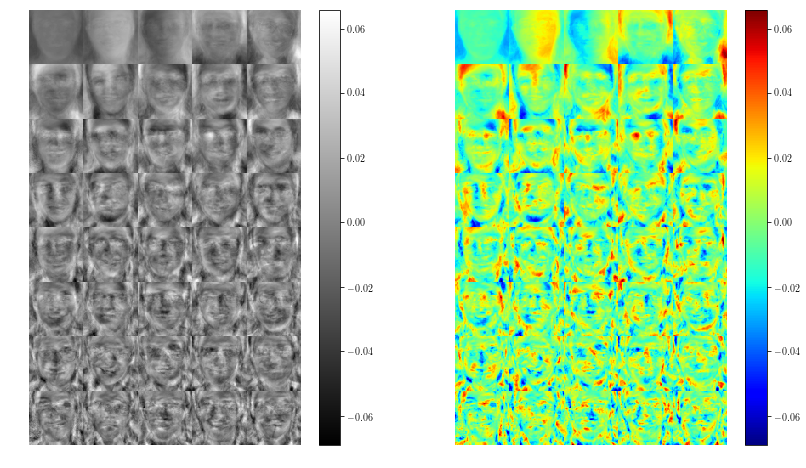

In [61]:
figure(figsize(2*num_cols + 4, num_rows))
for i, cmap in enumerate(['gray', 'jet']):
    plt.subplot(1, 2, i+1)
    plt.imshow(overview_eigenfaces, cmap), plt.colorbar()
    plt.axis('off');

### Analyze the eigenvalues

How many non-zero eigenvalues do we have?

In [62]:
tol =  s.max() * max(X.shape) * np.finfo(float64).eps
np.count_nonzero(s > tol)

131

In [63]:
print("The last two eigenvalues are:")
print(s[-2], s[-1])

The last two eigenvalues are:
646.395991897 4.76382776951e-12


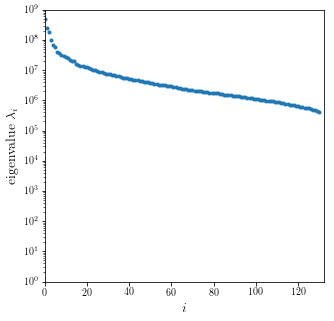

In [65]:
figure(figsize(5,5))
plt.semilogy(s**2, '.')
plt.ylim([1, 1e9])
plt.xlim([0, len(s)])
plt.rc('text', usetex=True)
plt.rc('font', family='sans')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'eigenvalue $\lambda_i$', fontsize=14);

### Reconstruct images from the training set adding one eigenface at a time

In [66]:
# img = image that should be reconstructed
# avg_img = the average image from the database
# eigenfaces = the eigenfaces images

#Processing one eigenface
def reconstruct_image(img, avg_img, eigenfaces, num_eigenfaces):
    N = 64
    #Take original image and subtract average
    img_zeromean = img - avg_img
    #Create a set of empty images with length number of eigenfaces + 1 
    recon_images = zeros((N * N, num_eigenfaces + 1))
    #For tests, save the rmse for each recon image
    rmse = zeros(num_eigenfaces + 1)
    
    #frobenius norm of image
    nfactor = numpy.linalg.norm(img)
    
    # num_eigenfaces + 1 steps
    # if     n = 0: recon_image = normed average avg
    # else   recon_image = recon_image + scalarproduct(eigenface_i, img_zeromean) *eigenface_i
    for n in range(num_eigenfaces + 1):
        if n == 0:
            recon_img = np.copy(avg_img)
            recon_images[:, 0] = avg_img
            rmse[0] = norm(img - avg_img) / nfactor
        elif n < num_eigenfaces + 1:
            eigenface = eigenfaces[:, n-1].reshape((N * N))
            recon_img += np.dot(eigenface, img_zeromean) * eigenface
            recon_images[:, n] = recon_img
            rmse[n] = numpy.linalg.norm(recon_img - img) / nfactor
    return recon_img, recon_images, rmse

Reconstruct two random images from the database.

In [67]:
# index of the two images in the database
recon_ids = [idx for idx, filename in enumerate(filenames) 
             if re.search('steidl|maier', filename)]
res = list()
overviews = list()
#Process the images and create an overview
for i, idx in enumerate(recon_ids):
    res.append(reconstruct_image(images[:, idx], avg, u, num_images - 1))
    overview, num_cols, num_rows = create_overview_picture(res[i][1])
    overviews.append(overview)

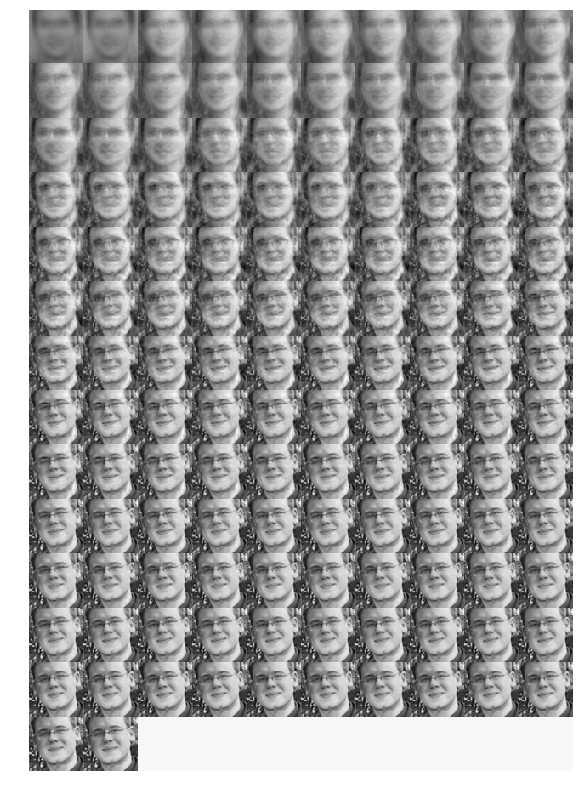

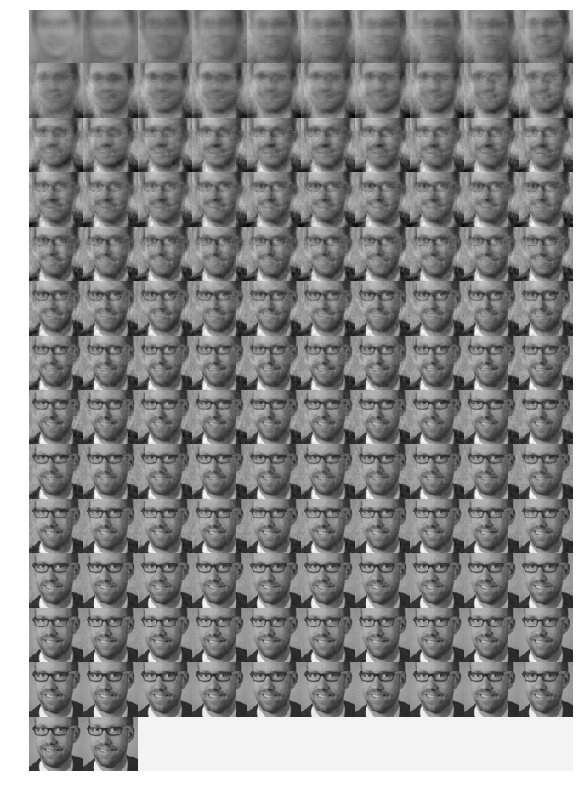

In [68]:
for overview in overviews:
    figure(figsize(num_cols, num_rows))
    plt.imshow(overview, 'gray')
    plt.axis('off');

RMSE image 72: 8.983106871602485e-16
RMSE image 113: 1.5185557630186302e-15


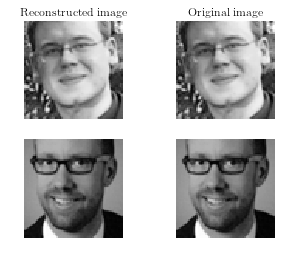

In [69]:
num_results = len(res)
figure(figsize(5, 2 * len(res)))
for i in range(num_results):
    recon_img, recon_images, rmse = res[i]
    plt.subplot(num_results, 2, 2*i+1)
    plt.imshow(recon_img.reshape(N, N), 'gray')
    plt.axis('off')
    if (i == 0):
        plt.title('Reconstructed image')
    plt.subplot(num_results, 2, 2*i+2)
    plt.imshow(images[:,recon_ids[i]].reshape(N, N), 'gray')
    plt.axis('off')
    if (i == 0):
        plt.title('Original image')
    print('RMSE image {0}: {1}'.format(recon_ids[i], rmse[-1]))

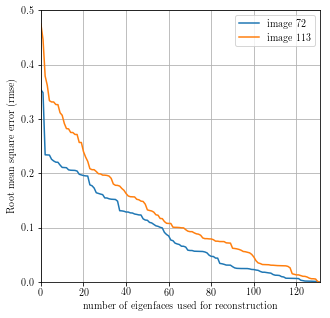

In [70]:
figure(figsize(5, 5))
legend = list()
for i, idx in enumerate(recon_ids):
    recon_img, recon_images, rmse = res[i]
    legend.append('image {0}'.format(recon_ids[i]))
    plt.plot(rmse)
plt.xlim([0, num_images-1])
plt.ylim([0, .5])
plt.xlabel('number of eigenfaces used for reconstruction')
plt.ylabel('Root mean square error (rmse)')
plt.legend(legend, loc='upper right');
plt.grid()

### Reconstruct the test image

In [71]:
recon_img, recon_images, rmse = reconstruct_image(test, avg, u, num_images - 1)

In [72]:
overview, num_cols, num_rows = create_overview_picture(recon_images)

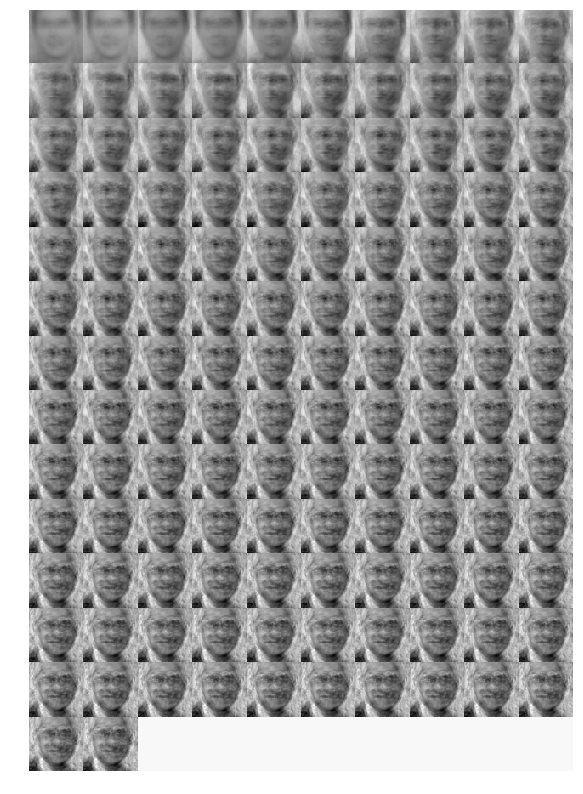

In [73]:
figure(figsize(num_cols, num_rows))
plt.imshow(overview, 'gray')
plt.axis('off');

RMSE: 0.18874140455289945


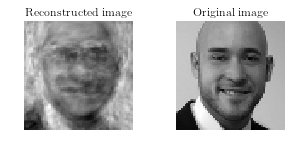

In [74]:
figure(figsize(5,2))
plt.subplot(1,2,1)
plt.imshow(recon_img.reshape(N, N), 'gray')
plt.title('Reconstructed image')
plt.axis('off');
plt.subplot(1,2,2),
plt.imshow(test.reshape(N, N), 'gray')
plt.title('Original image')
plt.axis('off')
print('RMSE: {0}'.format(rmse[-1]))

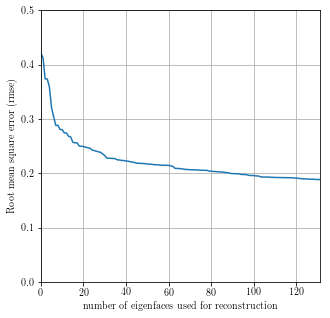

In [75]:
figure(figsize(5, 5))
plt.plot(rmse)
plt.xlim([0, num_images-1]), plt.ylim([0, .5])
plt.xlabel('number of eigenfaces used for reconstruction')
plt.ylabel('Root mean square error (rmse)')
plt.grid()

#### Using more eigenvectors

In [76]:
recon_img, recon_images, rmse = reconstruct_image(test, avg, u, N * N)

RMSE: 3.1530229406370702e-15


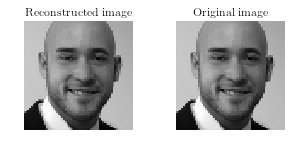

In [77]:
figure(figsize(5,2))
plt.subplot(1,2,1)
plt.imshow(recon_img.reshape(N, N), 'gray')
plt.title('Reconstructed image')
plt.axis('off');
plt.subplot(1,2,2),
plt.imshow(test.reshape(N, N), 'gray')
plt.title('Original image')
plt.axis('off')
print('RMSE: {0}'.format(rmse[-1]))

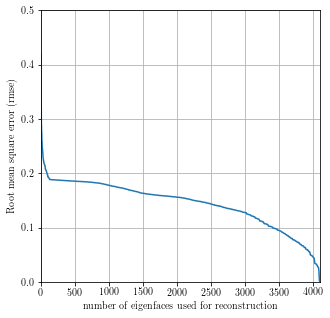

In [78]:
figure(figsize(5, 5))
plt.plot(rmse)
plt.xlim([0, N * N]), plt.ylim([0, .5])
plt.xlabel('number of eigenfaces used for reconstruction')
plt.ylabel('Root mean square error (rmse)')
plt.grid()